This file does an analysis of the correlation between shoreline change and wave model output
Based on the correlations, the data is clutered into different groups and saved for nb3, where the BN models are created.


In [1]:
proxy = 'WM'
islet_id = 1
atoll = 'Nanumea'
number_shoreline_segments = 200 # should match previous notebook

# File Setup

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime
import itertools
from shapely.geometry import LineString, shape
import pyproj
import xarray as xr
import scipy
import pickle
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans

# Load the data

In [3]:
with open('Processed_data_and_output/shorelines_dict.json','rb') as fp:
    shorelines_dict = pickle.load(fp)

In [4]:
# Reload dictionary of dates from file
with open('dates_dict.pkl', 'rb') as f:
    dates_dict = pickle.load(f)

# Data Formatting

In [5]:
for key,item in shorelines_dict.items():
    item = pd.DataFrame.from_dict(item,orient='index').T
    item['island'] = key[0]
    item['proxy'] = key[1]
    item['id'] = key[2]
    
    shorelines_dict.update({
        key:item
    })

In [6]:
df_all_shoreline_data = pd.concat([item for key,item in shorelines_dict.items()])

In [7]:
df_all_shoreline_data.index.rename('position',inplace=True)
df_all_shoreline_data.reset_index(drop=False,inplace=True)

In [8]:
df_all_shoreline_data = df_all_shoreline_data[df_all_shoreline_data.position<number_shoreline_segments] #some error points

In [9]:
# Optional - can use some coordinates to filter out some data which you may not want to model
# # Drop shoreline change values from the peninsular
# transformer2 = \
#     pyproj.Transformer.from_crs(pyproj.CRS("EPSG:32760"),pyproj.CRS("EPSG:4326")) 

# df_all_shoreline_data['y_with_nan'] = [y if transformer2.transform(x,y)[0]>-5.697555 else np.nan for x,y in zip(df_all_shoreline_data.x,df_all_shoreline_data.y) ]

# df_all_shoreline_data.dropna(inplace=True)

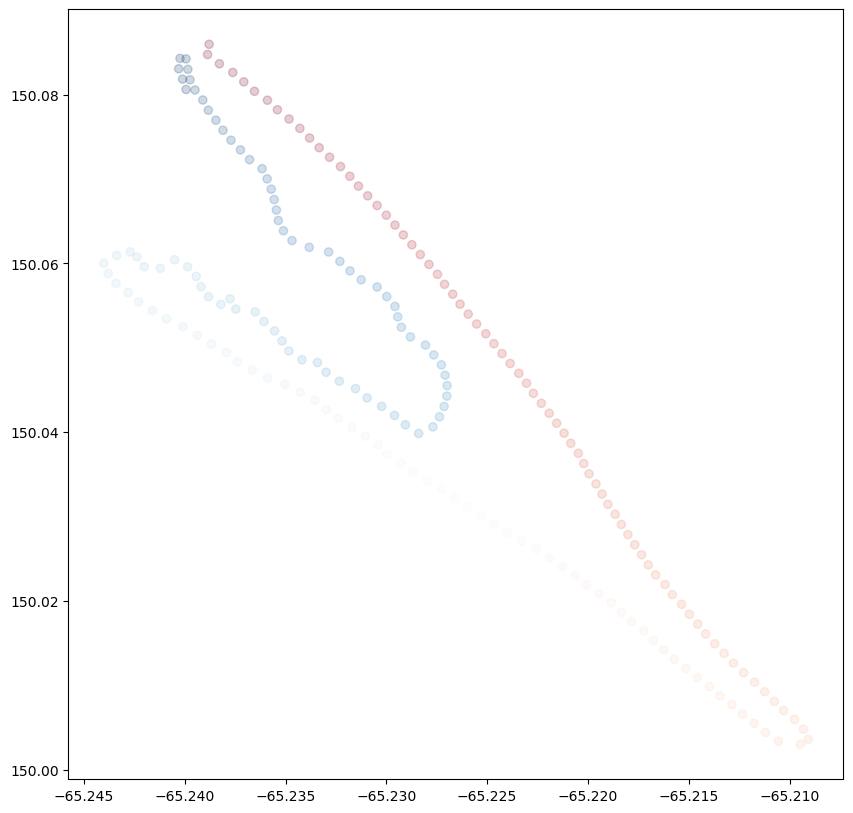

In [10]:
# Reset position zero point to be the most northerly point
transects_position_corrected_dict = {}

for year2,group in df_all_shoreline_data.groupby(['year2','island','proxy','id']):
    group['square'] = group.y**2#+group.x**2
    zero_point = (list(group[group.square==np.max(group.square)].position)[0])
    group['position'] = [x-zero_point if x>=zero_point else x-zero_point+1+np.max(group.position) for x in group.position]
    
    transects_position_corrected_dict.update({
        year2:group
    })
    
df_all_shoreline_data = pd.concat(transects_position_corrected_dict).reset_index(drop=True)

# Plot the shoreline position

fig = plt.figure(figsize=(10,10))

df_plot = df_all_shoreline_data[(df_all_shoreline_data.year2==np.unique(df_all_shoreline_data.year2)[0])&(df_all_shoreline_data.island==atoll)&(df_all_shoreline_data.id==islet_id)]

output = plt.scatter(df_plot.x,df_plot.y,
                     c=df_plot.position,
                     cmap='RdBu',
                     alpha=0.2)


In [11]:
# Select proxy, islet and atoll defined at top of the notebook
max_year = 2021 # Limit the max year in the data due to lack of wave model output
df_shoreline = df_all_shoreline_data[(df_all_shoreline_data.proxy==proxy)&(df_all_shoreline_data.island==atoll)&(df_all_shoreline_data.id==islet_id)&(df_all_shoreline_data.year2<=max_year)]

In [12]:
df_all_shoreline_data

position          x        x+n           y         y+n        lon  \
0             2 -65.238285 -65.237622  150.083645  150.082612  86.784247   
1             3 -65.237622 -65.237076  150.082612  150.081502  86.784247   
2             4 -65.237076 -65.236546  150.081502  150.080382  86.784247   
3             5 -65.236546 -65.235903  150.080382  150.079326  86.784247   
4             6 -65.235903 -65.235408  150.079326  150.078196  86.784246   
...         ...        ...        ...         ...         ...        ...   
15358        70 -65.210250 -65.209804  150.006641  150.005523  86.784238   
15359        71 -65.209804 -65.238782  150.005523  150.085997  86.784238   
15360        72 -65.238782 -65.238870  150.085997  150.084860  86.784247   
15361        73 -65.238870 -65.238264  150.084860  150.084037  86.784247   
15362        74 -65.238264 -65.237547  150.084037  150.083204  86.784247   

             lat  m_shoreline  m_transect      x_avg  ...  intersect_distance  \
0     -85.525538    -1.558398    0.641684 -65.237953  ...           -0.000027   
1     -85.525538    -2.031907    0.492148 -65.237349  ...           -0.000045   
2     -85.525538    -2.114306    0.472968 -65.236811  ...           -0.000156   
3     -85.525538    -1.641080    0.609355 -65.236224  ...           -0.000128   
4     -85.525538    -2.284599    0.437714 -65.235655  ...           -0.000078   
...          ...          ...         ...        ...  ...                 ...   
15358 -85.525539    -2.508576    0.398633 -65.210027  ...           -0.000023   
15359 -85.525539    -2.777136    0.360083 -65.224293  ...            0.001207   
15360 -85.525538    12.879220   -0.077644 -65.238826  ...           -0.000025   
15361 -85.525538    -1.358827    0.735929 -65.238567  ...            0.000006   
15362 -85.525538    -1.161223    0.861161 -65.237905  ...            0.000188   

       transect_angle  avg_slope_change  shoreline_direction     year1  \
0           32.687656         14.404750            57.312344  2002.375   
1           26.204032          1.584610            63.795968  2002.375   
2           25.312668         -4.524004            64.687332  2002.375   
3           31.356239          0.769490            58.643761  2002.375   
4           23.639649          0.226099            66.360351  2002.375   
...               ...               ...                  ...       ...   
15358       21.733836         -9.767450            68.266164  2002.375   
15359       19.803097          3.197122           250.196903  2002.375   
15360       -4.439792          9.499955            94.439792  2002.375   
15361       36.350424         -6.147521            53.649576  2002.375   
15362       40.733746         14.272761            49.266254  2002.375   

             year2   island  proxy  id        square  
0      2003.041667  Nanumea     WM   1  22525.100535  
1      2003.041667  Nanumea     WM   1  22524.790388  
2      2003.041667  Nanumea     WM   1  22524.457228  
3      2003.041667  Nanumea     WM   1  22524.120982  
4      2003.041667  Nanumea     WM   1  22523.804129  
...            ...      ...    ...  ..           ...  
15358  2023.958333  Nanumea     WM   1  22501.992199  
15359  2023.958333  Nanumea     WM   1  22501.657016  
15360  2023.958333  Nanumea     WM   1  22525.806500  
15361  2023.958333  Nanumea     WM   1  22525.465133  
15362  2023.958333  Nanumea     WM   1  22525.218018  

[15363 rows x 27 columns]

# Load summary wave data

In [13]:
# Load the data which is monthly summary and put it into an xarray
nanumea_spectra_dict = scipy.io.loadmat('Preprocessed_datasets/spectra/Nanumea_spec.mat')

# Convert date formate to standard datetime.datetime format
days_since_jan_1979 = (nanumea_spectra_dict['tm']-np.min(nanumea_spectra_dict['tm']))[0,:]

dates_list = []
for timedelta in days_since_jan_1979:
    dates_list.append(datetime.datetime(1979,1,1)+datetime.timedelta(days=int(timedelta)))
    
dirs_list = [x[0] for x in nanumea_spectra_dict['dirs']]
dirs_list = dirs_list-np.min(dirs_list)
frqs = [x[0] for x in nanumea_spectra_dict['frqs']]

In [14]:
xr_E_MM = xr.DataArray(data=nanumea_spectra_dict['E_MM'],coords=[dates_list,frqs,dirs_list],
                    dims=['time','freq','dirr'])

### Create feature for mean wave energy

In [15]:
# # Convert the wave energy dataframes to wave energy anomaly, removing seasonality
# Commented out since it didn't help with modelling, but leaving in here for possible future investigation
# dates_indexed = pd.DatetimeIndex(np.array(xr_E_MM.time))
# xr_E_MM_anom = xr_E_MM.copy()
# for month in np.arange(1,13,1):
#     xr_E_MM_anom[[True if x.month==month else False for x in dates_indexed],:,:] = \
#                       xr_E_MM[[True if x.month==month else False for x in dates_indexed],:,:]-\
#                       np.mean(xr_E_MM[[True if x.month==month else False for x in dates_indexed],:,:],axis=1)
# xr_E_MM = xr_E_MM_anom.copy()

# Correlation between wave energy and shoreline change (integrated frequency)

In [16]:
years = np.sort(np.unique(df_shoreline.year2))

In [17]:
# pd.options.mode.chained_assignment = None  # default='warn'

# def calc_correlations_array(days,window_size,xr_E):
#     ''' 
#     create correlation xarrays over different time periods using either mean or 95th percentile wave energy model output
#     integrated over frequency
#     '''
#     xr_E = xr_E.copy()
    
#     years = np.unique(df_shoreline.year2)

#     xr_E_last_month_t_0 = np.mean(xr_E[(xr_E.time>np.datetime64(dates_dict[years[0]]-datetime.timedelta(days=days)))&(xr_E.time<np.datetime64(dates_dict[years[0]])),:,:],axis=0) #-datetime.timedelta(days=days-window_size)
#     xr_E_last_month_t_0 = xr_E_last_month_t_0.expand_dims(dim={'years':len(years)},axis=0)
#     xr_E_last_month_t_0 = xr_E_last_month_t_0.assign_coords(years=years)
#     xr_E_last_month_t_0 = xr_E_last_month_t_0.copy()

#     for year,idx in zip(years[1:],np.arange(1,len(years),1)):
#         xr_E_last_month = xr_E[(xr_E.time>np.datetime64(dates_dict[year]-datetime.timedelta(days=days)))&(xr_E.time<np.datetime64(dates_dict[year])),:,:] #-datetime.timedelta(days=days-window_size)

#         xr_E_last_month = np.mean(xr_E_last_month,axis=0)

#         xr_E_last_month_t_0[idx,:,:] = np.array(xr_E_last_month)

#     # for year,df_year in df_shoreline.groupby('year2'):
#     df_other_years = df_shoreline[df_shoreline.year2!=years[0]]
#     df_first_year = df_shoreline[df_shoreline.year2==years[0]]

#     # Collapes corrs for 2D plot
#     df_first_year = df_shoreline[df_shoreline.year2==np.min(df_shoreline.year2)]

#     (index,row) = [(index,row) for index,row in df_first_year.iterrows()][0]

#     shoreline_change_per_year_single_position = {}
#     for year in years:
#         df = df_shoreline[df_shoreline.year2==year]
#         df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
#         df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

#         shoreline_change_per_year_single_position.update({
#             year:float(df.iloc[0].intersect_distance)
#         })


#     xr_TOB = xr.DataArray.from_dict({'dims':['years'],
#                             'data':list(shoreline_change_per_year_single_position.values())})
#     xr_TOB = xr_TOB.assign_coords(years=years)
#     xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
#                                      'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

#     xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
#     xr_corrs = xr_corrs.sortby('dirr')
#     xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
#     xr_corr_init = xr_corrs.integrate('freq')

#     position = np.arange(0,np.max(df_shoreline.position)+1,1)

#     xr_corr_init = xr_corr_init.expand_dims(dim={'position':position},axis=0)
#     xr_corr_init = xr_corr_init.assign_coords(position=position)
#     xr_corr_init = xr_corr_init.copy()

#     for index,row in df_first_year.iterrows():

#         shoreline_change_per_year_single_position = {}
#         for year in years:
#             df = df_shoreline[df_shoreline.year2==year]
#             df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
#             df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

#             shoreline_change_per_year_single_position.update({
#                 year:float(df.iloc[0].intersect_distance)
#             })


#         xr_TOB = xr.DataArray.from_dict({'dims':['years'],
#                                 'data':list(shoreline_change_per_year_single_position.values())})
#         xr_TOB = xr_TOB.assign_coords(years=years)
#         xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
#                                          'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

#         xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
#         xr_corrs = xr_corrs.sortby('dirr')
#         xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
#         xr_corrs = xr_corrs.fillna(0)
#         xr_corrs = xr_corrs.integrate('freq')

#         xr_corr_init[row.position,:] = np.array(xr_corrs)
        
#     xr_corr_init['dirr'] = xr_corr_init.dirr*180/np.pi

#     # Create some reference points for reading the plot
#     west_most_point = df_first_year[df_first_year.x==np.min(df_first_year.x)]
#     north_most_point = df_first_year[df_first_year.y==np.max(df_first_year.y)]
#     south_most_point = df_first_year[df_first_year.y==np.min(df_first_year.y)]
        
#     return(xr_corr_init,west_most_point,north_most_point,south_most_point)


In [18]:
# corrs_dict = {}
# days_list = [31,62,93,124,120,180,244,360]
# for wave_label,xr_E in zip(['mean'],[xr_E_MM]):
#     for day in days_list:
#         xr_corr_init,west_most_point,north_most_point,south_most_point = calc_correlations_array(day,day,xr_E)
#         corrs_dict.update({
#             (day,wave_label):{
#                 'corr':xr_corr_init,
#                 'west':west_most_point,
#                 'north':north_most_point,
#                 'south':south_most_point
#             }
#         })
#         break
#     break
  

In [19]:
# xr_corr_init = xr_corr_init.fillna(0)

In [20]:
# n_clusters = 10

# fig = plt.figure(figsize=(10,5))

# ax1 = plt.subplot2grid((1,2),(0,0),zorder=100)
# ax2 = plt.subplot2grid((1,2),(0,1),zorder=100)

# xr.plot.pcolormesh(xr_corr_init,ax=ax1,vmin=-1,vmax=1,cmap='bwr')

# # for n in np.arange(0,n_clusters,1):
# #     ax2.plot(xr_corr_init.dirr,fit.cluster_centers_[n])

# ax1.set_xlabel('Wave energy direction (degrees)')
# ax2.set_xlabel('Wave energy direction (degrees)')
# ax1.set_ylabel('Shoreline position')
# ax2.set_ylabel('Correlation')

# ax1.set_title('Wave energy-shoreline change correlation heatmap')
# ax2.set_title('Correlation profile for sampled points')
# plt.show()

# Correlation Polar Plots

In [21]:
# Settings for correlation plot between wave energy and shoreline change.
# Wave energy is during a time period relative to the shoreline change time (x days before to x+y days before)
days = 90 #beginning of period for wave energy averaging (days prior)
window_size = 90 # number of days since beginning of time period to include in wave energy averaging
xr_E = xr_E_MM.copy() ; dataset_name = 'mean' # Can select mean (xr_E_MM, 'mean') or 95th percentile (xr_E_95, '95th') model output for correlation

days: 90, window size: 90
Each polar plot shows correlation between wave energy and a single shoreline segment
Radius indicates wave energy refrequency
Direction represents wave energy from difference directions
Color is the strength of the correlation. Blue is negative correlation (wave energy associated with erosion, and red is positive correlation (wave energy associated with accretion).


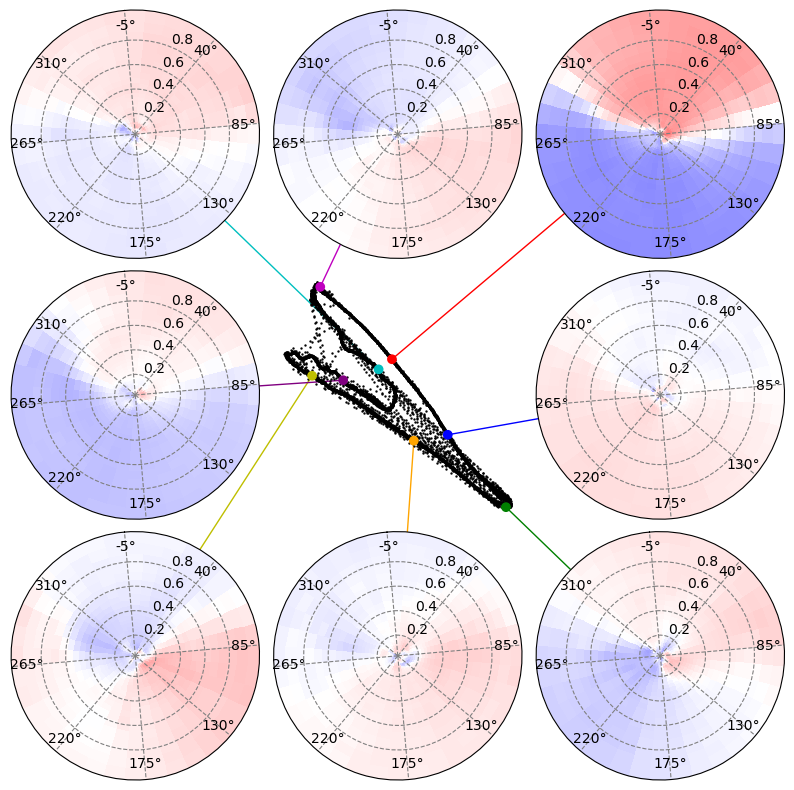

In [22]:
pd.options.mode.chained_assignment = None  # default='warn'

print(f'days: {days}, window size: {window_size}')

fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((3,3),(0,2),projection='polar',zorder=100)
ax2 = plt.subplot2grid((3,3),(1,2),projection='polar',zorder=100)
ax3 = plt.subplot2grid((3,3),(2,2),projection='polar',zorder=100)
ax4 = plt.subplot2grid((3,3),(2,1),projection='polar',zorder=100)
ax5 = plt.subplot2grid((3,3),(2,0),projection='polar',zorder=100)
ax6 = plt.subplot2grid((3,3),(1,0),projection='polar',zorder=100)
ax7 = plt.subplot2grid((3,3),(0,0),projection='polar',zorder=100)
ax8 = plt.subplot2grid((3,3),(0,1),projection='polar',zorder=100)

ax9 = plt.subplot2grid((3,3),(1,1))

years = np.unique(df_shoreline.year2)

xr_E_last_month_t_0 = np.mean(xr_E[(xr_E.time>np.datetime64(dates_dict[years[0]]-datetime.timedelta(days=days)))&(xr_E.time<np.datetime64(dates_dict[years[0]]-datetime.timedelta(days=days-window_size))),:,:],axis=0)
xr_E_last_month_t_0 = xr_E_last_month_t_0.expand_dims(dim={'years':len(years)},axis=0)
xr_E_last_month_t_0 = xr_E_last_month_t_0.assign_coords(years=years)
xr_E_last_month_t_0 = xr_E_last_month_t_0.copy()

for year,idx in zip(years[1:],np.arange(1,len(years),1)):
    xr_E_last_month = xr_E[(xr_E.time>np.datetime64(dates_dict[year]-datetime.timedelta(days=days)))&(xr_E.time<np.datetime64(dates_dict[year]-datetime.timedelta(days=days-window_size))),:,:]
#     xr_E_95_last_month = xr_E_95[(xr_E_95.time>(dates_dict[year]-datetime.timedelta(days=days)))&(xr_E_95.time<(dates_dict[year])),:,:]
    
    xr_E_last_month = np.mean(xr_E_last_month,axis=0)
    
    xr_E_last_month_t_0[idx,:,:] = np.array(xr_E_last_month)

# for year,df_year in df_shoreline.groupby('year2'):
df_other_years = df_shoreline[df_shoreline.year2!=years[0]]
df_first_year = df_shoreline[df_shoreline.year2==years[0]]
position_selection = np.unique(df_first_year.position)[::int((len(df_first_year)/8))][0:8]#[1,25,50,75,100,125,150,175]

df_first_year_position_selected = df_first_year[df_first_year.position.isin(position_selection)]

for (index,row),ax in zip(df_first_year_position_selected.iterrows(),[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    
    shoreline_change_per_year_single_position = {}
    for year in years:
        df = df_shoreline[df_shoreline.year2==year]
        df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
        df = df[df.euclidean_distance==np.min(df.euclidean_distance)]
        
        shoreline_change_per_year_single_position.update({
            year:float(df.iloc[0].intersect_distance)
        })

        
    xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                            'data':list(shoreline_change_per_year_single_position.values())})
    xr_TOB = xr_TOB.assign_coords(years=years)
    xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                     'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

    xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
    xr_corrs = xr_corrs.sortby('dirr')
    xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180

    xr.plot.pcolormesh(xr_corrs,ax=ax,vmin=-1,vmax=1,cmap='bwr',add_colorbar=False)#,add_colorbar=[False if ax!=ax1 else True for ax in [ax]][0])
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks(ax.get_yticks()[:-2])
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.tick_params(axis="x",direction="in",pad=-18)
    handles, labels = ax.get_legend_handles_labels()
    
# ax1.legend(handles,labels,loc='right',bbox_to_anchor=(0.5,0.5))
    
colours = ['r','b','g','orange','y','purple','c','m']
# Create centre plot
ax9.scatter(df_shoreline.x,df_shoreline.y,c='k',s=0.5)
ax9.scatter(df_first_year_position_selected.x,df_first_year_position_selected.y,c=colours)
ax9.axis('off')


for c,index,ax in zip(colours,np.arange(0,len(colours),1),[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    # Create connections
    axb = fig.add_axes(ax.get_position(), frameon=False,zorder=-1000)
    axb.axis('off')
    
    con = ConnectionPatch(xyA=(df_first_year_position_selected.reset_index().loc[index,'x'],
                               df_first_year_position_selected.reset_index().loc[index,'y']),
                          xyB=(np.mean(axb.get_xlim()),np.mean(axb.get_ylim())), coordsA="data", coordsB="data",
                          axesA=ax9, axesB=axb, color=c,zorder=-1000)

    ax9.add_artist(con)
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig(f'Processed_data_and_output/figures/polar_example_plot_{dataset_name}_{window_size}.png')

print('Each polar plot shows correlation between wave energy and a single shoreline segment')
print('Radius indicates wave energy refrequency')
print('Direction represents wave energy from difference directions')
print('Color is the strength of the correlation. Blue is negative correlation (wave energy associated with erosion, and red is positive correlation (wave energy associated with accretion).')

In [23]:
# Plot the correlations around the shoreline integrating over frequencies
# make this one with a little slider

# Correlations with integrated frequency, with island map

In [24]:
df_first_year = df_shoreline[df_shoreline.year2==np.min(df_shoreline.year2)]

(index,row) = [(index,row) for index,row in df_first_year.iterrows()][0]

shoreline_change_per_year_single_position = {}
for year in years:
    df = df_shoreline[df_shoreline.year2==year]
    df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
    df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

    shoreline_change_per_year_single_position.update({
        year:float(df.iloc[0].intersect_distance)
    })


xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                        'data':list(shoreline_change_per_year_single_position.values())})
xr_TOB = xr_TOB.assign_coords(years=years)
xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                 'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
xr_corrs = xr_corrs.sortby('dirr')
xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
xr_corr_init = xr_corrs.integrate('freq')

position = np.arange(0,np.max(df_shoreline.position)+1,1)

xr_corr_init = xr_corr_init.expand_dims(dim={'position':position},axis=0)
xr_corr_init = xr_corr_init.assign_coords(position=position)
xr_corr_init = xr_corr_init.copy()

for index,row in df_first_year.iterrows():
    
    shoreline_change_per_year_single_position = {}
    for year in years:
        df = df_shoreline[df_shoreline.year2==year]
        df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
        df = df[df.euclidean_distance==np.min(df.euclidean_distance)]
        
        shoreline_change_per_year_single_position.update({
            year:float(df.iloc[0].intersect_distance)
        })

        
    xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                            'data':list(shoreline_change_per_year_single_position.values())})
    xr_TOB = xr_TOB.assign_coords(years=years)
    xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                     'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

    xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
    xr_corrs = xr_corrs.sortby('dirr')
    xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
    xr_corrs = xr_corrs.fillna(0)
    xr_corrs = xr_corrs.integrate('freq')

    xr_corr_init[row.position,:] = np.array(xr_corrs)
xr_corr_init['dirr'] = xr_corr_init.dirr*180/np.pi

In [25]:
left_most_point = df_first_year[df_first_year.x==np.min(df_first_year.x)]
north_most_point = df_first_year[df_first_year.y==np.max(df_first_year.y)]
south_most_point = df_first_year[df_first_year.y==np.min(df_first_year.y)]

Coloured horizontal lines on left correspond to coloured points on right hand plot.
Black line shows direction shoreline segment is facing


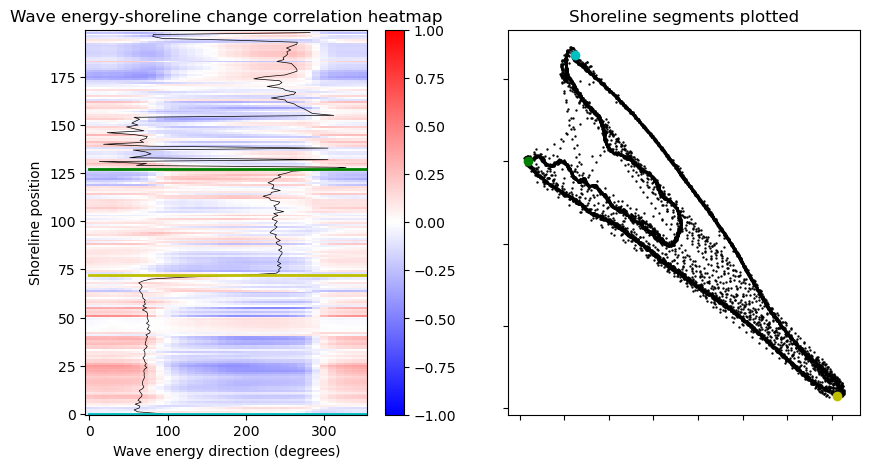

In [26]:
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

xr.plot.pcolormesh(xr_corr_init,cmap='bwr',vmin=-1,vmax=1,add_colorbar=True,ax=ax1)

ax2.scatter(df_shoreline.x,df_shoreline.y,c='k',s=0.5)

ax2.scatter(left_most_point.x,left_most_point.y,c='g')
ax2.scatter(north_most_point.x,north_most_point.y,c='c')
ax2.scatter(south_most_point.x,south_most_point.y,c='y')


df_year = df_shoreline[df_shoreline.year2==np.min(df_shoreline.year2)]
df_year = df_year.sort_values('position')
ax1.plot(df_year.shoreline_direction,df_year.position,c='k',lw=0.5)

ax1.plot([0,360],[left_most_point.position,left_most_point.position],c='g',lw=2)
ax1.plot([0,360],[north_most_point.position,north_most_point.position],c='c',lw=2)
ax1.plot([0,360],[south_most_point.position,south_most_point.position],c='y',lw=2)

ax1.set_xlabel('Wave energy direction (degrees)')
ax1.set_ylabel('Shoreline position')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax1.set_title('Wave energy-shoreline change correlation heatmap')
ax2.set_title('Shoreline segments plotted')

print('Coloured horizontal lines on left correspond to coloured points on right hand plot.')
print('Black line shows direction shoreline segment is facing')
plt.show()


# Create Multidimensional Array of correlations

New correlation array has dimesions of wave energy direction, frequency, time lag, dataset (either mean wave energy or 95th percentile), and shoreline change position

In [27]:
def find_coordinate_index(data_array, coordinate_name, value):
    """
    Find the index of a coordinate in an xarray equal to a particular value.
    
    Parameters:
        data_array (xarray.DataArray): The xarray data array.
        coordinate_name (str): The name of the coordinate to search.
        value: The value to search for in the coordinate.
    
    Returns:
        tuple or None: The index of the coordinate if found, or None if not found.
    """
    coordinate = data_array[coordinate_name]
    
    index = coordinate.to_index().get_indexer(value, method='nearest')
    if isinstance(index, int):
        return (index,)
    elif isinstance(index, slice):
        return index.indices(len(coordinate))
    else:
        return None

In [28]:
# create correlation xarrays over different time periods using either mean or 95th percentile
pd.options.mode.chained_assignment = None  # default='warn'

def calc_correlations_array_multidim(month,xr_E,anomaly):
    '''
    calculates multidimensional matrix of correlation between wave energy and shoreline change
    '''
    
    xr_E = xr_E.copy()
    
    years = np.unique(df_shoreline.year2)

    # from IPython import embed
    # embed()

    # current_time_index = find_coordinate_index(xr_E,'time',
    #                                            np.array(xr_E[xr_E.time>np.datetime64(dates_dict[years[0]])].time)[0])[0]-1
    current_time_index = np.argmin(np.abs(xr_E.time.values-np.array(xr_E[xr_E.time>np.datetime64(dates_dict[years[0]])].time)[0]))-1

    xr_E_last_month_t_0 = np.mean(xr_E[(current_time_index-month):(current_time_index-(month-1)),:,:],axis=0)
    xr_E_init = xr_E_last_month_t_0.copy()
    xr_E_last_month_t_0 = xr_E_last_month_t_0.expand_dims(dim={'years':len(years)},axis=0)
    xr_E_last_month_t_0 = xr_E_last_month_t_0.assign_coords(years=years)
    xr_E_last_month_t_0 = xr_E_last_month_t_0.copy()
    
    for year,idx in zip(years[1:],np.arange(1,len(years),1)):
        # current_time_index = find_coordinate_index(xr_E,'time',
        #                                            np.array(xr_E[xr_E.time>np.datetime64(dates_dict[year])].time)[0])[0]-1
        current_time_index = np.argmin(np.abs(xr_E.time.values-np.array(xr_E[xr_E.time>np.datetime64(dates_dict[year])].time)[0]))-1
        
        xr_E_last_month = np.mean(xr_E[(current_time_index-month):(current_time_index-(month-1)),:,:],axis=0)
        if anomaly:
            xr_E_last_month = xr_E_last_month-xr_E_init
        xr_E_last_month = np.mean(xr_E_last_month,axis=0)
        xr_E_last_month_t_0[idx,:,:] = np.array(xr_E_last_month)


    # for year,df_year in df_shoreline.groupby('year2'):
    df_other_years = df_shoreline[df_shoreline.year2!=years[0]]
    df_first_year = df_shoreline[df_shoreline.year2==years[0]]

    # Collapes corrs for 2D plot
        
    df_first_year = df_shoreline[df_shoreline.year2==np.min(df_shoreline.year2)]

    (index,row) = [(index,row) for index,row in df_first_year.iterrows()][0]

    shoreline_change_per_year_single_position = {}
    for year in years:
        
        df = df_shoreline[df_shoreline.year2==year]
        df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
        df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

        shoreline_change_per_year_single_position.update({
            year:float(df.iloc[0].intersect_distance)
        })


    xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                            'data':list(shoreline_change_per_year_single_position.values())})
    xr_TOB = xr_TOB.assign_coords(years=years)
    xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                     'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

    xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
    xr_corrs = xr_corrs.sortby('dirr')
    xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
    xr_corr_init = xr_corrs

    position = np.arange(0,np.max(df_shoreline.position)+1,1)

    xr_corr_init = xr_corr_init.expand_dims(dim={'position':position},axis=0)
    xr_corr_init = xr_corr_init.assign_coords(position=position)
    xr_corr_init = xr_corr_init.copy()

    for index,row in df_first_year.iterrows():

        shoreline_change_per_year_single_position = {}
        for year in years:
            df = df_shoreline[df_shoreline.year2==year]
            df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
            df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

            shoreline_change_per_year_single_position.update({
                year:float(df.iloc[0].intersect_distance)
            })


        xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                                'data':list(shoreline_change_per_year_single_position.values())})
        xr_TOB = xr_TOB.assign_coords(years=years)
        xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                         'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

        xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
        xr_corrs = xr_corrs.sortby('dirr')
        xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
        xr_corrs = xr_corrs.fillna(0)
        xr_corrs = xr_corrs.integrate('freq')

        xr_corr_init[row.position,:] = np.array(xr_corrs)
        
    xr_corr_init['dirr'] = xr_corr_init.dirr*180/np.pi
            
    return(xr_corr_init)


In [29]:
months_list = np.arange(1,13,1)
# Set up initial array and loop over 1 month of data for the previous 12 months and calculate correlations
xr_corr_multidim = calc_correlations_array_multidim(months_list[0],xr_E_MM,False)

xr_corr_multidim = xr_corr_multidim.expand_dims(dim={'window_size':months_list},axis=[3])
xr_corr_multidim = xr_corr_multidim.assign_coords(window_size=months_list)
xr_corr_multidim = xr_corr_multidim.copy()
    
for month in months_list[1:]:
    xr_corr = calc_correlations_array_multidim(month,xr_E_MM,False)
    
    xr_corr_multidim[:,:,:,month-1] = xr_corr #month -1 because it's the index not the month itself

xr_corr_multidim.to_netcdf('Processed_data_and_output/correlations.nc')

In [30]:
xr_corr_multidim

<xarray.DataArray (position: 200, freq: 37, dirr: 36, window_size: 12)> Size: 26MB
array([[[[-1.20708268e-02, -2.19773944e-01, -1.45061403e-01, ...,
           1.05063718e-01,  1.60865422e-01,  3.69616610e-02],
         [-7.94982442e-03, -2.27800534e-01, -1.61520937e-01, ...,
           1.43326153e-01,  1.81942494e-01,  5.83853377e-02],
         [-4.12381548e-03, -2.09355969e-01, -1.42531688e-01, ...,
           1.85971228e-01,  1.92999882e-01,  7.84866292e-02],
         ...,
         [-1.93421236e-03, -2.04049893e-01, -1.14835885e-02, ...,
           6.87873611e-02,  1.53700774e-01, -2.67806301e-02],
         [-1.53932925e-02, -1.92692934e-01, -1.28921878e-02, ...,
           6.81001636e-02,  1.46741194e-01, -7.64817841e-03],
         [-1.94292514e-02, -1.86543024e-01, -3.18411081e-02, ...,
           7.04117836e-02,  1.43584674e-01,  8.54734946e-03]],

        [[-1.20708268e-02, -2.19773944e-01, -1.45061403e-01, ...,
           1.05063718e-01,  1.60865422e-01,  3.69616610e-02],
         [-7.94982442e-03, -2.27800534e-01, -1.61520937e-01, ...,
           1.43326153e-01,  1.81942494e-01,  5.83853377e-02],
         [-4.12381548e-03, -2.09355969e-01, -1.42531688e-01, ...,
           1.85971228e-01,  1.92999882e-01,  7.84866292e-02],
...
         [ 8.44072368e-02, -1.47817658e-01, -1.03975727e-01, ...,
          -7.35711711e-02,  3.81287222e-01,  5.35685373e-02],
         [ 8.86614756e-02, -1.53510754e-01, -1.07076414e-01, ...,
          -5.43462425e-02,  3.46274121e-01,  9.88626619e-02],
         [ 9.98049384e-02, -1.51910364e-01, -1.16597926e-01, ...,
          -4.07269919e-02,  3.23242354e-01,  1.33507830e-01]],

        [[ 1.14454791e-01, -1.35802004e-01, -1.62670992e-01, ...,
          -1.03573677e-02,  2.90985345e-01,  1.68491876e-01],
         [ 1.45931877e-01, -1.21984866e-01, -2.07807095e-01, ...,
          -1.45603546e-02,  2.64161417e-01,  1.44542583e-01],
         [ 1.84511264e-01, -1.07655751e-01, -2.39018871e-01, ...,
          -2.69056516e-02,  2.25158438e-01,  8.33378933e-02],
         ...,
         [ 8.44184852e-02, -1.47811910e-01, -1.03971283e-01, ...,
          -7.35692018e-02,  3.81290898e-01,  5.35707808e-02],
         [ 8.86700342e-02, -1.53504925e-01, -1.07073501e-01, ...,
          -5.43445416e-02,  3.46277963e-01,  9.88647544e-02],
         [ 9.98129651e-02, -1.51903661e-01, -1.16595756e-01, ...,
          -4.07258644e-02,  3.23245359e-01,  1.33509672e-01]]]])
Coordinates:
  * freq         (freq) float64 296B 0.033 0.0363 0.0399 ... 0.8274 0.9096 1.0
  * position     (position) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * dirr         (dirr) float64 288B 0.0 10.0 20.0 30.0 ... 330.0 340.0 350.0
  * window_size  (window_size) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

# Linear relationships in an N-dimensional array

Find correlations between correlations of shoreline segements and wave energy (i.e. find which shoreline segment's correlations are most similar to each other)

In [31]:
# Calculate correlations between all pairs of arrays
corr_matrix = np.corrcoef(xr_corr_multidim.values.reshape(number_shoreline_segments, -1))

# Create dictionary to store similarities
array_similarities_dict = {}
for i in range(number_shoreline_segments):
    array_similarities_dict[i] = {j: corr_matrix[i, j] for j in range(number_shoreline_segments-1)}

This plot shows the pairwise correlations between shoreline segements, based on their correlations with wave energy


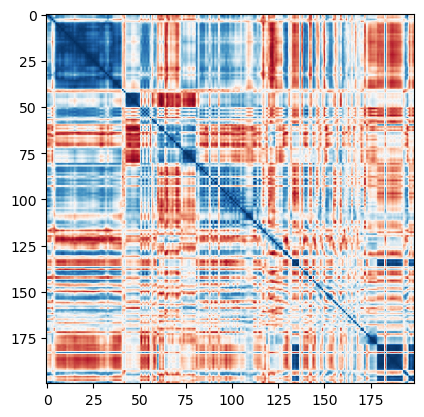

In [44]:
df = pd.DataFrame.from_dict(array_similarities_dict,orient='index')

plt.imshow(df,'RdBu')
plt.savefig('Processed_data_and_output/figures/confusion_matrix.png')

print('This plot shows the pairwise correlations between shoreline segements, based on their correlations with wave energy')

# Cluster based on Correlations

**Need to Manually select optimal number of clusters (n_clusters) based on plot below**

Increase the number of clusters to make the pattern vertically consistent.

Aim to have the fewest number of clusters which separates the data well.

The BNs are not greatly impacted by the number of clusters (plus or minus one won't have much impact)

In [40]:
n_clusters = 7

In [41]:
df = pd.DataFrame.from_dict(array_similarities_dict,orient='index')
fit = KMeans(n_clusters=n_clusters).fit(df)
clusts = fit.predict(df)
df_new = df.copy()
df_new = df_new.reset_index().rename(columns={'index':'position'})
df_new.index = clusts
df_new = df_new.sort_index()

In [42]:
len_clusts = []
for clust in np.unique(clusts):
    len_clusts.append(len(df_new[df_new.index==clust]))

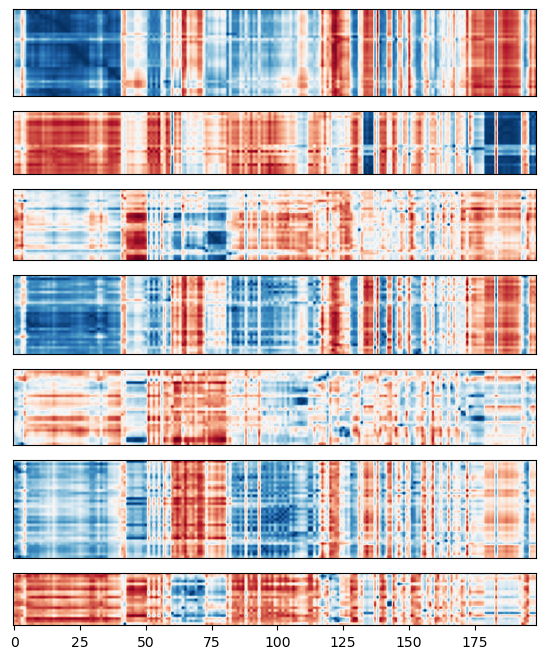

In [43]:

fig, ax = plt.subplots(n_clusters, 1, figsize=(8,8), gridspec_kw={'height_ratios': 
                                                   len_clusts})

i = 0
for clust in np.unique(clusts):
    df_clust_temp = df_new[df_new.index==clust]
    # ax1 = plt.subplot2grid((n_clusters,1),(i,0),zorder=100)
    ax[i].imshow(df_clust_temp.drop('position',axis=1),'RdBu')
    ax[i].axes.get_yaxis().set_visible(False)
    if clust!=np.max(clusts):
        ax[i].axes.get_xaxis().set_visible(False)
    i+=1

plt.savefig('Processed_data_and_output/figures/clustered_confusion_matrix.png')

# Save configured clusters

In [45]:
# Saves these clusts for tests in the other file
dict_temp = df_new['position'].reset_index().set_index(['position']).to_dict()['index']
with open('Processed_data_and_output/clusters.json','wb') as fp:
    pickle.dump(dict_temp,fp)

# Determine previous shoreline change value

In [46]:
# Ensure the dataframe is sorted by time
df_shoreline = df_shoreline.sort_values(by='year2')

# Get unique years
years = df_shoreline['year2'].unique()

# Iterate over years starting from the second year
for i in range(1, len(years)):
    current_year = years[i]
    previous_year = years[i - 1]
    
    current_year_data = df_shoreline[df_shoreline['year2'] == current_year]
    previous_year_data = df_shoreline[df_shoreline['year2'] == previous_year]
    
    for idx, current_row in current_year_data.iterrows():
        # Calculate distances to all points in the previous year
        distances = np.sqrt((previous_year_data['x'] - current_row['x'])**2 + (previous_year_data['y'] - current_row['y'])**2)
        
        # Find the index of the closest point
        closest_idx = distances.idxmin()
        
        # Retrieve the intersect distance of the closest point
        closest_intersect_distance = previous_year_data.loc[closest_idx, 'intersect_distance']
        
        # Store the intersect distance in the dataframe
        df_shoreline.at[idx, 'previous'] = closest_intersect_distance

df_shoreline = df_shoreline.fillna(0)

# Save shoreline change data

In [47]:
df_shoreline.to_csv('Processed_data_and_output/modified_dataset.csv')